In [121]:
import pandas as pd
import numpy as np

def turn_to_hr(target):
    time = target.hour + target.minute/60
    return (time)

def turn_to_hr_str(target):
    time = int(target.split(":")[0]) + int(target.split(":")[1])/60
    return time

In [81]:
'''
ref_table = pd.read_csv("Hubs Compare Table.csv")
ref_table.dropna(how = "all", axis = 1, inplace = True)
ref_table.columns = ["GS_Country", "GS_Hub","M_Country", "M_Hub" ]
ref_table = ref_table.drop(0, axis = 0)
'''

In [153]:
ref_table = pd.read_csv("Hub list.csv")
ref_table["Masterfile_name"] = ref_table.Ref_City + "-"+ ref_table.Country



In [241]:
# Read files 

#distances = pd.read_excel("Simple Routes.xlsx", sheet_name = 0)
distances = pd.read_csv("inter_distances.csv")
distances.columns = ["", 'Origin Country', 'Destination Country', 'From', 'To', 'Distance', 'Time Format', 'Time', 'Duration']
schedule = pd.read_csv("tn_rs.csv") # Read the current network (Used/Nonused)
schedule.replace("Ryton Gateway", "Ryton", inplace = True)


In [242]:
print(f"there are {len(distances)} rows in the distacnes file")

there are 461487 rows in the distacnes file


In [280]:
# Gather the list of cities

hub_list_in_GS =  ref_table["City"].tolist()
org_list = schedule["Org. GTW"].unique().tolist()

hub_ref = {}
count = 0
for x in org_list:
    for y in hub_list_in_GS:
        if x in y:
            msname = ref_table[ref_table["City"] == y]["Masterfile_name"]
            hub_ref[x] =  msname.values[0]
            break
    
    else:
        print(f"{x} is not in the list")
        count = count+1
 
print(count / len(org_list))
        
count = 0
des_list = schedule["Dst. GTW"].unique().tolist()
for x in des_list:
    for y in hub_list_in_GS:
        if x in y:
            msname = ref_table[ref_table["City"] == y]["Masterfile_name"]
            hub_ref[x] =  msname.values[0]
            break
    
    else:
        print(f"{x} is not in the list")
        count = count+1
        
print(count)

NPKK is not in the list
0.03225806451612903
COMBS LA VILLE is not in the list
1


In [281]:
schedule["agg"] = schedule["Org. GTW"] + schedule["Dst. GTW"]

In [282]:
for x in schedule.index:
    a = schedule.loc[x, "Distance in km"]
    if type(a) == str:
        schedule.loc[x, "Distance in km"] = 0

In [283]:
schedule["Speed"] = schedule["Distance in km"] / schedule["Travel time"]
schedule = schedule[schedule.Speed <= 100] # Get rid of those columns with impossible values

In [284]:
# In the current schedule, 1 route usually has several rows because of the different schedule arrangement.
# Only choose the row that is the most reasonable.
list_for_df = []
for agg in schedule["agg"].unique():
    agg_info = schedule[schedule["agg"] == agg]
    pick = agg_info[agg_info["Speed"] == agg_info["Speed"].max()]
    #list_for_df.append([agg_info["Org. GTW"].unique()[0], agg_info["Dst. GTW"].unique()[0], agg_info["Travel time"].median() , agg_info["Distance in km"].median()])
    list_for_df.append([pick["Org. GTW"].tolist()[0], pick["Dst. GTW"].tolist()[0], pick["Travel time"].tolist()[0] , pick["Distance in km"].tolist()[0]])

In [285]:
agg_info["Speed"].max()

64.16666666666667

In [286]:
# To delete the duplicated routes, we create a new dataset called "compare"

compare = pd.DataFrame(list_for_df, columns = ["Org. GTW", "Dst. GTW", "Travel time", "Distance in km"])
compare["bing distance"] = ""
compare["bing driving time"] = ""

In [287]:
dist_col_name = "Distance"
time_col_name = "Duration"


def find_dist(org, dst):
    if org in hub_ref.keys():
        org = hub_ref[org]
    else:
        print(f"in the route of {org} and {dst}, {org} can't find")
    if dst in hub_ref.keys():
        dst = hub_ref[dst]
    else:
        print(f"in the route of {org} and {dst}, {dst} can't find")
        
    km = distances.loc[(distances["From"] == org) & (distances["To"] == dst), dist_col_name]
    time = distances.loc[(distances["From"] == org) & (distances["To"] == dst), time_col_name]
    return [km, time]

In [288]:
for row in compare.index:
    org = compare.loc[row, "Org. GTW"]
    dst = compare.loc[row, "Dst. GTW"]
    ans = find_dist(org, dst)

    if len(ans[0]) != 0:
        compare.loc[row, "bing distance"] = ans[0].values[0]
        compare.loc[row, "bing driving time"] = ans[1].values[0]

in the route of Eindhoven-Noord-NL and COMBS LA VILLE, COMBS LA VILLE can't find
in the route of PZ 77 (Lahr)-DE and COMBS LA VILLE, COMBS LA VILLE can't find
in the route of NPKK and Regensburg, NPKK can't find


In [289]:
distances.loc[(distances["From"] == hub_ref["Regensburg"]) & (distances["To"] == hub_ref["Wien 1"]), :]

,,Origin Country,Destination Country,From,To,Distance,Time Format,Time,Duration


In [290]:
compare_found = compare[compare["bing distance"] != ""].sort_values("Distance in km")
print(f"{len(compare_found)} out of {len(schedule)} are covered")

58 out of 172 are covered


In [291]:
import seaborn as sns
import matplotlib.pyplot as plt

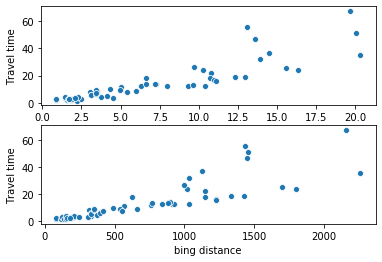

In [292]:
fix = plt.subplot(2,1,1)
sns.scatterplot(x = "bing driving time", y = "Travel time", data = compare_found)

fix = plt.subplot(2,1,2)
sns.scatterplot(x = "bing distance", y = "Travel time", data = compare_found)


# Using simple equations to model the travel time using the driving time.
Minimize the MSE

In [293]:
compare.dropna(how = "any", inplace = True)

def tt_est(daily_max, rest, offset, dt_offset, driving_time):
    # daily_max # assume 12 at this moment
    # rest # assume the bus driver have to rest at least 8 hours between 2 days
    # offset # assume the bus need to drive out and in to the hub, and it takes time
    # dt_offset # adjust the speed.
    driving_time = driving_time*dt_offset
    hour = driving_time % daily_max
    ext_hour = driving_time //daily_max* (rest+daily_max)  # Calculate the time it need for every extended day
    
    return hour + ext_hour + offset # 1 means the buffer time

def cal_mse(df):
    return sum((df["est_tt"] - df["Travel time"])**2)



In [309]:
compare = compare[compare["bing driving time"] != ""]

2688.879685416667


/Users/yi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


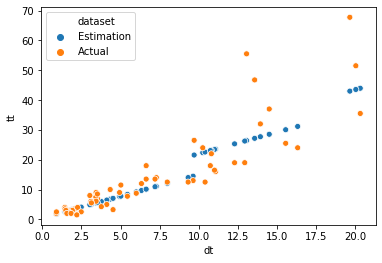

In [310]:

compare["est_tt"] = compare.apply(lambda row: tt_est(14,7,0.5,1.45,row["bing driving time"]), axis = 1)
print(cal_mse(compare))

# Visualize
set1 = compare.loc[:, ["bing driving time", "est_tt"]]
set1.columns = ["dt", "tt"] 
set2 = compare.loc[:, ["bing driving time", "Travel time"]]
set2.columns = ["dt", "tt"]
plot_dataset = pd.concat([set1.assign(dataset='Estimation'), set2.assign(dataset='Actual')])
plot_dataset
sns.scatterplot(data = plot_dataset , x = "dt", y = "tt", hue = "dataset")

In [311]:
dm = [x for x in range(10, 15)]
rest = [x for x in range(8, 12)]
offset = [x/2 for x in range(0, 4)]
dt_offset = [x/10 for x in range(10, 15)]
grid_search = [(a, b, c, d) for a in dm for b in rest for c in offset for d in dt_offset]
gs_result = []
for a, b, c, d in grid_search: 
    compare["est_tt"] = compare.apply(lambda row: tt_est(a,b,c,d,row["bing driving time"]), axis = 1)
    gs_result.append([a, b, d, d, cal_mse(compare)])

/Users/yi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [312]:
gs_result = pd.DataFrame(gs_result)
best_set = gs_result.loc[gs_result[4] == gs_result[4].min(), 0:3].values.tolist()[0]

In [313]:
# using the best set to train the rest of the data
a, b, c, d = best_set
compare["est_tt"] = compare.apply(lambda row: tt_est(a,b,c,d,row["bing driving time"]), axis = 1)

/Users/yi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


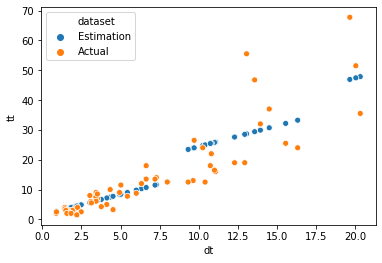

In [314]:
# Visualize
set1 = compare.loc[:, ["bing driving time", "est_tt"]]
set1.columns = ["dt", "tt"] 
set2 = compare.loc[:, ["bing driving time", "Travel time"]]
set2.columns = ["dt", "tt"]
plot_dataset = pd.concat([set1.assign(dataset='Estimation'), set2.assign(dataset='Actual')])
plot_dataset
sns.scatterplot(data = plot_dataset , x = "dt", y = "tt", hue = "dataset")

In [315]:
# Calculate the estimated travel time
distances["est_tt"] = 0
distances["est_tt"] = distances.apply(lambda row: tt_est(a,b,c,d,row["Duration"]), axis = 1)

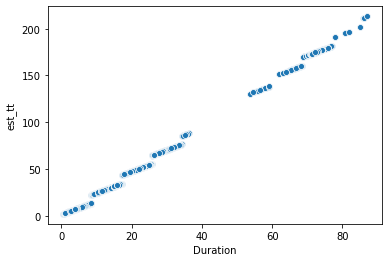

In [316]:
sns.scatterplot(data = distances, x = "Duration", y = "est_tt")

In [317]:
distances.to_csv("travel time.csv")

# Using KNN to model the travle time ## Failed

In [199]:
# Convert the dataframe to join with the distances file
df_to_join = compare.iloc[:, 0:3].copy()
df_to_join.columns = ["From", "To", "Travel time"]

df_to_join.From = df_to_join.apply(lambda row: hub_ref[row.From] if row.From in hub_ref.keys() else row.From, axis = 1)
df_to_join.To = df_to_join.apply(lambda row: hub_ref[row.To] if row.To in hub_ref.keys() else row.To, axis = 1)

In [212]:
inter_distances = distances[distances["Origin Country"] != distances["Destination Country"]] # Get rid of the routes traveling in the same country
df_with_tt = pd.merge(inter_distances, df_to_join, on = ["From", "To"], how = "left")

In [219]:
tt_and_distances = df_with_tt.loc[:, ["Distance Km", "Travel time"]]

In [217]:
import pylab as pl
from matplotlib.pyplot import figure
import numpy as np
import math

In [220]:
# USING KNN ALGO TO PREDICT MISSING Travel time BASED ON DISTANCE VALUE

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np
import sklearn.impute 

imputer = sklearn.impute.KNNImputer(n_neighbors=2, weights="uniform")
#result = imputer.fit_transform(tt_and_distances)

result #

array([[656.309,   7.   ],
       [749.381,  24.25 ],
       [641.489,  14.625],
       ...,
       [455.309,   6.   ],
       [258.545,   6.25 ],
       [258.66 ,   6.25 ]])

In [223]:
new_tt = pd.DataFrame(result, columns = ["Distances km", "New_TT"])

In [225]:
df_with_tt["New_TT"] = new_tt["New_TT"]

In [226]:
df_with_tt

,Origin Country,Destination Country,From,To,Distance Km,Time,,Travel time,New_TT
0,AT,DE,Hub Graz-AT,PZ 01 (Ottendorf-Okrilla)-DE,656.309,06:50:00,NaN,NaN,7.000
1,AT,DE,Hub Graz-AT,PZ 04 (Radefeld/Leipzig)-DE,749.381,06:25:00,NaN,NaN,24.250
2,AT,DE,Hub Graz-AT,PZ 08 (Neumark)-DE,641.489,05:40:00,NaN,NaN,14.625
3,AT,DE,Hub Graz-AT,PZ 14 (Börnicke)-DE,917.102,07:49:00,NaN,NaN,23.625
4,AT,DE,Hub Graz-AT,PZ 15 (Rüdersdorf)-DE,942.471,07:58:00,NaN,NaN,23.625
...,...,...,...,...,...,...,...,...,...
111929,HU,SI,Budapest OLK-HU,Ljubljana-SI,454.150,04:15:00,NaN,NaN,6.000
111930,SI,HU,Ljubljana-SI,Budapest NPKK (OE)-HU,491.141,04:32:00,NaN,NaN,13.750
111931,SI,HU,Ljubljana-SI,Budapest OLK-HU,455.309,04:14:00,NaN,NaN,6.000
111932,LV,LT,Riga-LV,Kaunas-LT,258.545,03:57:00,NaN,NaN,6.250


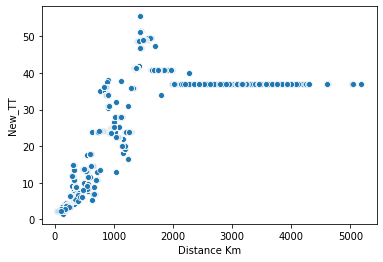

In [313]:
sns.scatterplot(x = "Distance Km", y = "New_TT", data = df_with_tt)